In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import copy

from sklearn.preprocessing import LabelEncoder

from scipy.stats import ttest_ind, sem, t
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols

import statsmodels.api as sm


plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 14})

In [3]:
df = pd.read_csv('Health_insurance.csv')

In [4]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


# EDA(Data Analysis and Preparation)

In [5]:
df.shape

(1338, 7)

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


* **Looking at the age column, data is uniformly distributed**

* **Very few people have more than 2 children. 75% of the people have 2 or less children**

* **Charges are skewed to higer values**

<p style = 'color:red; font-size:23px; font-weight:900;'> Distribution of ‘bmi’, ‘age’ and ‘charges’ columns </p>

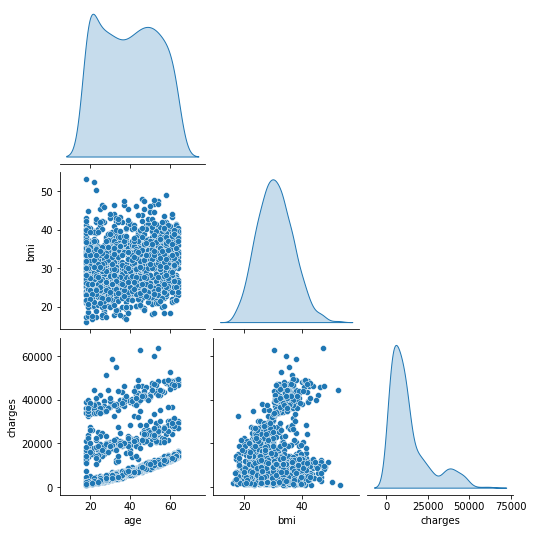

In [9]:
df_attr = df.iloc[:, [0,2,6]] # Select ‘age’, ‘bmi’ and ‘charges’ columns.

sns.pairplot(df_attr, diag_kind ="kde", corner = True)  #pariplot

* **Age column seems to be uniformly distributed**
* **BMI column seems to be normally distributed**
* **Charges colum -- Right Skewed Distribution --- charges are skewed to higer values**

<p style = "font-size:20px; color: #007580 "><strong> Measure of skewness of ‘bmi’, ‘age’ and ‘charges’ columns </strong></p> 

<a id = '4.1'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 4.1 Univariate analysis </h2> 

In [10]:
df_attr.skew()

age        0.055673
bmi        0.284047
charges    1.515880
dtype: float64

* **Age column seems to be uniformly distributed as seen in previous step and there is hardly any skewness**
* **BMI column seems to be normally distributed as seen in previous step and there is very less Skewness**
* **Charges column -- Right Skewed Distribution --- charges are skewed to higer values**

<p style = "font-size:20px; color: #007580 "><strong> Checking the presence of outliers in ‘bmi’, ‘age’ and ‘charges columns </strong></p> 

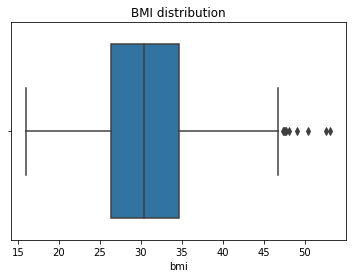

In [11]:
plt.title("BMI distribution");
sns.boxplot(x=df['bmi']);
plt.show();

* **Above plot shows, there are few points between 47 to 55, these are outliers as there are not included in the box of other observation i.e no where near the quartiles.**

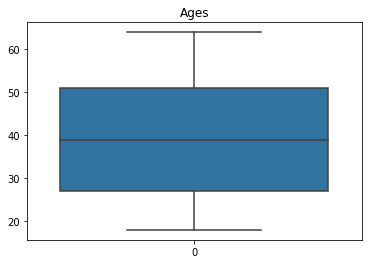

In [12]:
sns.boxplot(df['age'])
plt.title('Ages')
plt.show()

* **Above plot shows, there are no outliers in 'age' column**

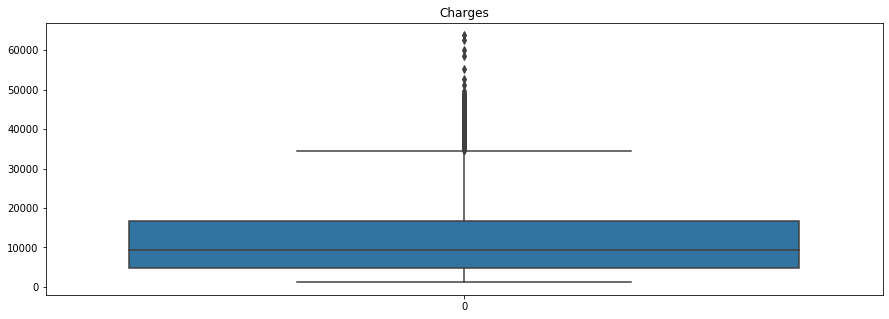

In [13]:
plt.figure(figsize= (15,5))
sns.boxplot(df['charges'])
plt.title('Charges')
plt.show()

* **Above plot shows, more points between 35000 to 55000, these are outliers as there are not included in the box of other observation i.e no where near the quartiles.**

<p style = "font-size:20px; color: #007580 "><strong> Distribution of categorical columns (include children) </strong></p> 

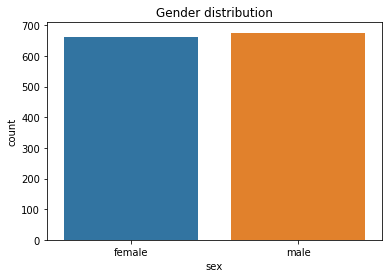

In [14]:
sns.countplot(df, x='sex')
plt.title('Gender distribution')
plt.show()

* **Above plot shows, Gender distribution is eqal**

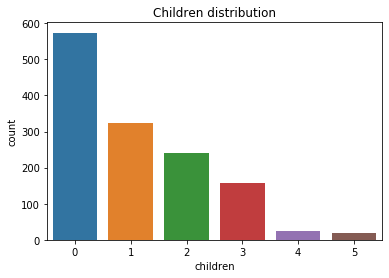

In [15]:
sns.countplot(df, x='children')
plt.title("Children distribution")
plt.show()

* **Above plot shows, there are very few customers who have 4 o 5 children and there are most customers who don't have children**

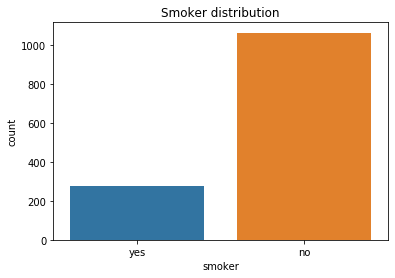

In [16]:
sns.countplot(df, x='smoker');
plt.title("Smoker distribution");
plt.show();

* **Above plot shows, there are more non-smokers than smokers in Insurance data frame**

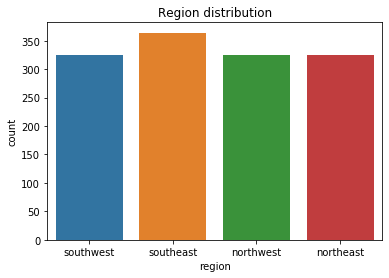

In [17]:
sns.countplot(df, x='region');
plt.title("Region distribution");
plt.show();

* **Above plot shows, Region distribution is almost equal**

<p style = "font-size:20px; color: #007580 "><strong> Pair plot that includes all the columns of the data frame </strong></p> 

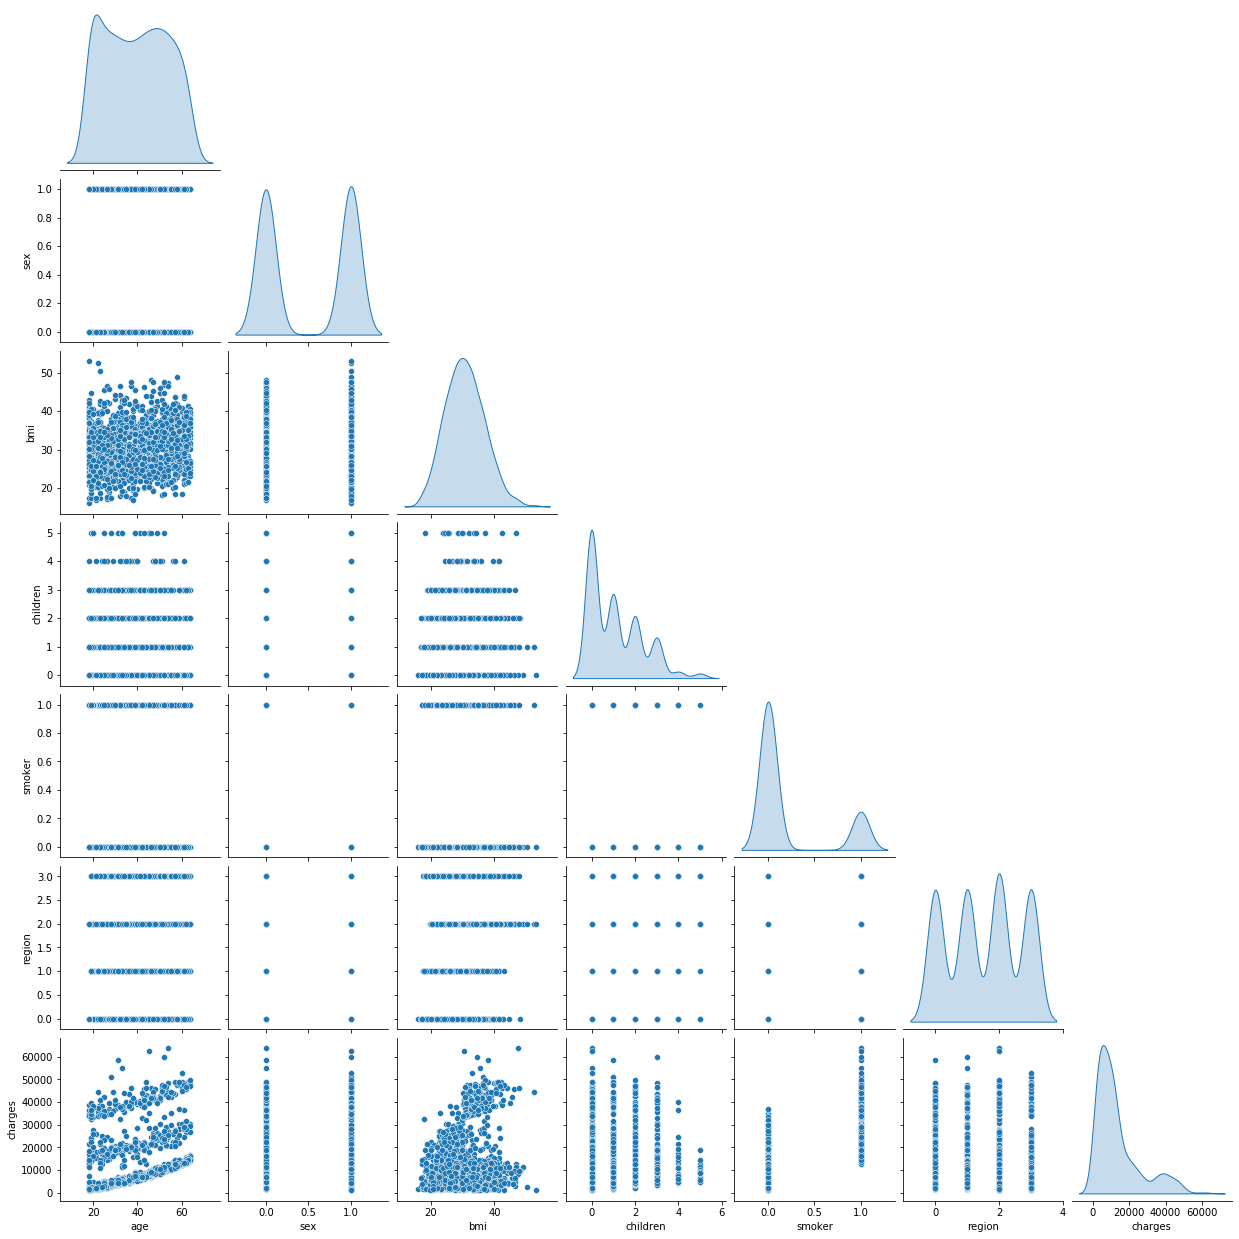

In [18]:
df_encoded = copy.deepcopy(df)

df_encoded.loc[:,['sex', 'smoker', 'region']] = df_encoded.loc[:,['sex', 'smoker', 'region']].apply(LabelEncoder().fit_transform)

sns.pairplot(df_encoded, diag_kind='kde', corner=True)
plt.show()

#### By looking into above graph, we can infer below points 

* **Smokers claimed more money than non-smokers**
* **BMI of male and female customers is almost same**

**But statistically we prove it using Hypothesis testing**

<a id = '4.2'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 4.2 Bivariate analysis and Hypothesis testing </h2> 

In [19]:
df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

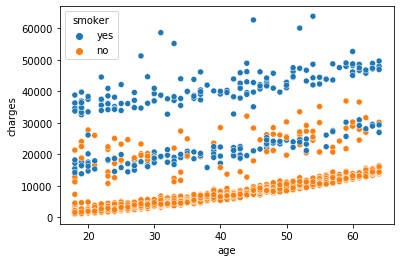

In [20]:
# Check the charges of smokers and non-smokers across different ages
sns.scatterplot(x='age', y='charges', hue='smoker', data=df)

#### By looking into above graph, we can say "charges of smokers and non-smokers are different". But is the difference statistically significant?

#### 1. State the H0 and Ha

* H<sub>0</sub>: x&#772;<sub>1</sub> = x&#772;<sub>2</sub>, or x&#772;<sub>2</sub> - x&#772;<sub>1</sub> = 0, **there is no difference in charges of smokers and non-smokers**

* H<sub>A</sub>: x&#772;<sub>2</sub> &ne; x&#772;<sub>1</sub>, or x&#772;<sub>2</sub> - x&#772;<sub>1</sub> &ne; 0, **there is a difference in charges of smokers and non-smokers**

#### 2. Decide the significance level: alpha = 0.05

#### 3. Identify the test-statistic: 2 sample t - test

#### 4. Calculate P_value using test-statistic/t-score

In [21]:
smoker_charges = df[df['smoker']=='yes'].charges
non_smoker_charges = df[df['smoker']=='no'].charges

t_statistic, p_value = ttest_ind(smoker_charges , non_smoker_charges)

print("t_statistic =",t_statistic)
print("p_value =",p_value)

t_statistic = 46.66492117272371
p_value = 8.271435842179102e-283


#### 5. Decide to Reject or Accept Null Hypothesis

In [22]:
if p_value < 0.05:
    print('Something is happening')
else:
    print('nothing is happening')

Something is happening


#### Hence we reject Null Hypothesis (we have enough (95% and 99%) evidence to prove that there is a difference in charges of smokers and non-smokers)

<p style = "font-size:20px; color: red; "><strong> b. Does bmi of males differ significantly from that of females? </strong></p> 

In [23]:
# Checking howmany male and female customers in Insurance Data frame
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

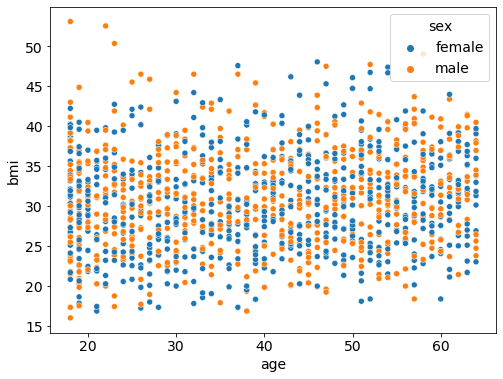

In [28]:
# Check the bmi of male and female customers accross different ages
sns.scatterplot(x='age', y='bmi', hue='sex', data=df)

#### By looking into above graph, we can say "bmi of male and female customers is same". But is it statistically significant?

#### 1. State the H0 and Ha

* H<sub>0</sub>: x&#772;<sub>1</sub> = x&#772;<sub>2</sub>, or x&#772;<sub>2</sub> - x&#772;<sub>1</sub> = 0, **bmi of male and female customers is same**

* H<sub>A</sub>: x&#772;<sub>2</sub> &ne; x&#772;<sub>1</sub>, or x&#772;<sub>2</sub> - x&#772;<sub>1</sub> &ne; **bmi of male and female customers is different**

#### 2. Decide the significance level: alpha = 0.05

#### 3. Identify the test-statistic: 2 sample t - test

#### 4. Calculate P_value using test-statistic/t-score

In [32]:
male_bmi = df[df['sex']=='male'].bmi
female_bmi = df[df['sex']=='female'].bmi

t_stats , p_value = ttest_ind(male_bmi, female_bmi)

print('T-stats', t_stats)
print('P-value', p_value)

T-stats 1.696752635752224
P-value 0.08997637178984932


#### 5. Decide to Reject or Accept Null Hypothesis

In [33]:
if p_value < 0.05:
    print('Something is happening')
else:
    print('nothing is happening')

nothing is happening


#### Hence we fail to reject Null Hypothesis (we have enough (95%) evidence to prove that bmi of male and female customers is same)

<p style = "font-size:20px; color: red"><strong> c. Is the proportion of smokers significantly different in different genders? </strong></p> 

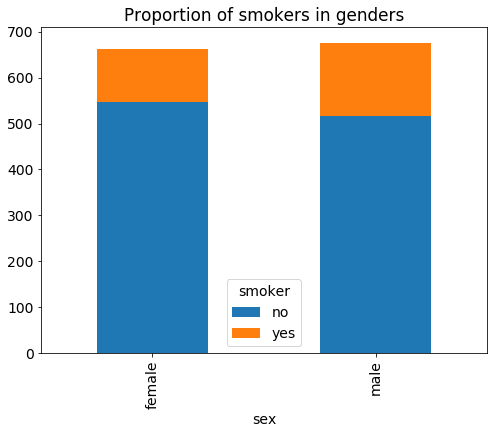

In [42]:
# Check the bmi of male and female customers accross different ages
smoker_genders_table = pd.crosstab(df['sex'],df['smoker'])
smoker_genders_table.plot(kind='bar', stacked=True)

plt.title('Proportion of smokers in genders')
plt.show()

#### By looking into above graph, we can say "the proportions of smokers in genders are not equal". But is the difference statistically significant?

#### 1. State the H0 and Ha

#### Ho = The proportions of smokers in genders are equal
#### Ha = The proportions of smokers in genders are not equal

In [67]:
male_smokers = df[df['sex']=='male'].smoker.value_counts()[1]
female_smokers = df[df['sex']=='female'].smoker.value_counts()[1]

n_male = df.sex.value_counts()[0]
n_female = df.sex.value_counts()[1]

print([female_smokers, male_smokers] , [n_female, n_male])

print(f'proportion of somkers in male, females = {round(115/662,2)}% ,{round(159/676,2)}% ')

[115, 159] [662, 676]
proportion of somkers in male, females = 0.17% ,0.24% 


#### 2. Decide the significance level: alpha = 0.05

#### 3. Identify the test-statistic: Z - test of Proportions

#### 4. Calculate P_value using test-statistic

In [68]:
t_stats , p_value = proportions_ztest([female_smokers, male_smokers] , [n_female, n_male])

print('T-stats', t_stats)
print('P-value', p_value)

T-stats -2.7867402154855503
P-value 0.005324114164320532


#### 5. Decide to Reject or Accept Null Hypothesis

In [69]:
if p_value < 0.05:
    print('Something is happening')
else:
    print('nothing is happening')

Something is happening


#### Hence we reject Null Hypothesis (we have enough (95%) evidence to prove that ,the proportions of smokers in genders are not equal)

<p style = "font-size:20px; color: red "><strong> d. Is the distribution of bmi across women with no children, one child and two children, the same? </strong></p> 

In [88]:
# Check the bmi of women with no children, one child and two children

zero_child = df[df['children'] == 0]
women_zero_child_bmi = zero_child[df['sex'] == 'female'].bmi

one_child = df[df['children'] == 1]
women_one_child_bmi = one_child[df['sex'] == 'female'].bmi

two_child = df[df['children'] == 2]
women_two_child_bmi = two_child[df['sex'] == 'female'].bmi



df1             = pd.DataFrame({'children': 'zero', 'bmi':women_zero_child_bmi})
df2             = pd.DataFrame({'children': 'one', 'bmi':women_one_child_bmi})
df3             = pd.DataFrame({'children': 'two', 'bmi':women_two_child_bmi})



children_bmi_df = pd.DataFrame()


children_bmi_df = children_bmi_df.append(df1)
children_bmi_df = children_bmi_df.append(df2)
children_bmi_df = children_bmi_df.append(df3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


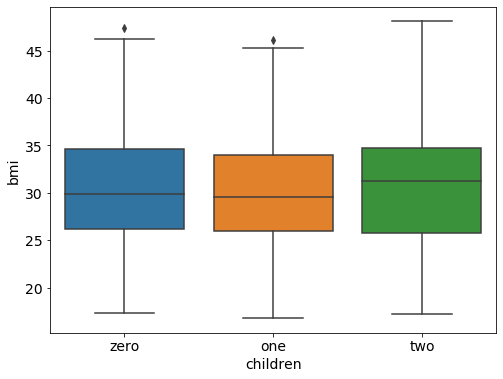

In [87]:
sns.boxplot(x='children', y='bmi', data=children_bmi_df)

In [111]:
children_bmi_df['children'].value_counts()

zero    289
one     158
two     119
Name: children, dtype: int64

#### The boxplots show almost similar shapes, location and spreads for women with 0, 1, and 2 children but few outlier for women with 0 and 1 child.

#### 1. State the H0 and Ha

#### Ho = $\mu1$ = $\mu2$ = $\mu3$  -- Women with no children, one child and two children has no effect on bmi
#### Ha = At least one $\mu$ differs -- Women with no children, one child and two children has an effect on bmi

#### 2. Decide the significance level: alpha = 0.05

#### 3. Identify the test-statistic

#### Here we have three groups. Analysis of variance can determine whether the means of three or more groups are different. ANOVA uses F-tests to statistically test the equality of means.

#### 4. Calculate P_value using ANOVA table

In [137]:
mod = ols('bmi ~ children', data= children_bmi_df).fit()
avo_table = sm.stats.anova_lm(mod, typ=2)

print(avo_table)

p_value = avo_table['PR(>F)'][0]

print('p_value = ',p_value)

                sum_sq     df         F    PR(>F)
children     24.590123    2.0  0.334472  0.715858
Residual  20695.661583  563.0       NaN       NaN
p_value =  0.7158579926754169


In [138]:
if p_value < 0.05:
    print('Something is happening')
else:
    print('nothing is happening')

nothing is happening


#### 5. Decide to Reject or Accept Null Hypothesis

<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Summary </h2> 
<br>
<br>
<strong>What happend so far?</strong>

<ol>
<li>Explored dataset stats and missing values of the dataset.</li>
<li>Checked the outliers in dataset, BMI and Charges columns are having outliers.</li>
<li>Difference in charges of smokers and non-smokers.</li>
<li>BMI of male and female customers is same.</li>
<li>Proportions of smokers in genders are not equal.</li>
<li>Women with no children, one child and two children has no effect on bmi.</li>
</ol>
   
<br>
   
